In this page we will continue from the LinearExample notebook, choosing to use the covariance summary statistics for the linear example. We will use a custom class to aim to increase customisability as well as trying to use dropout to get a distribution of outputs.

### plot helper function

In [23]:
def plot_loss(history, title="Loss curve"):
    """
    Plot training & validation loss stored in a Keras History object.
    Generates two stacked panels:
      • top: linear y-axis
      • bottom: semilog-y (base-10) axis
    """
    epochs = range(1, len(history.history["loss"]) + 1)

    fig, (ax_lin, ax_log) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # linear plot
    ax_lin.plot(epochs, history.history["loss"],     label="train")
    ax_lin.plot(epochs, history.history["val_loss"], label="val")
    ax_lin.set_ylabel("MSE")
    ax_lin.set_title(title + " (linear scale)")
    ax_lin.legend()
    ax_lin.grid(True, which="both", linestyle="--", linewidth=0.5)

    # semilog-y plot
    ax_log.semilogy(epochs, history.history["loss"],     label="train")
    ax_log.semilogy(epochs, history.history["val_loss"], label="val")
    ax_log.set_xlabel("Epoch")
    ax_log.set_ylabel("MSE (log scale)")
    ax_log.set_title(title + " (semilogy)")
    ax_log.legend()
    ax_log.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

### Custom NN

As before use keras.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

print("Successfully imported all modules")

Successfully imported all modules


Define our custom Neural Network, can add or remove layers accordingly

In [25]:
class NN(Model):

    def __init__(self,
                 no_params,
                 neurons=64,
                 dropout_prob = 0.0,
                 always_on_dropout = False
                 ):

        super(NN, self).__init__(name='NN') # inherits the parent class and names it (for debugging)

        self.neurons = neurons
        self.no_params = no_params # number of paramaters we output

        self.always_on_dropout = always_on_dropout # if true then we leave on for test passes

        # Define our layers
        self.l1 = Dense(neurons, activation='relu', name='l1')
        self.do1 = Dropout(rate=dropout_prob, name='do1') # dropout layer 1
        self.l2 = Dense(neurons, activation='relu', name='l2')
        self.do2 = Dropout(rate=dropout_prob, name='do2') # dropout layer 2
        # Applies linear activation which is just unchanged
        self.out =  Dense(no_params, activation="linear", name="out")

    def call(self, inputs, training=False):
        dropout_flag = training or self.always_on_dropout

        # Apply our custom layers
        x = self.l1(inputs)
        x = self.do1(x, training=dropout_flag)
        x = self.l2(x)
        x = self.do2(x, training=dropout_flag)
        x = self.out(x)

        return x    # output size = no_params

### Dataset generation

We make a similar function to before with only the one covariance option.

The scaling helps significantly to get good convergence

In [26]:
def simulate_batch(
        no_params,
        batch_size,
        theta_range = (0,10),
        n_per_sample=100,
        noise_std=0.5
):

    # Generate our theta, and random points which will be used to form the output variable
    theta = tf.random.uniform([batch_size, no_params, 1], *theta_range)     # (B, D, 1)
    X     = tf.random.uniform([batch_size, n_per_sample, no_params])        # (B, n, no_params)

    # Generate noise and then create output variable
    noise = noise_std * tf.random.normal([batch_size, n_per_sample, 1])  # (B, n, 1)
    y     = tf.matmul(X, theta) + noise                                  # (B, n, 1)

    mean_x = tf.reduce_mean(X, axis=1)                 # (B, D)
    mean_y = tf.reduce_mean(y, axis=1)                 # (B, 1) - used for if we have y intercept

    # Center both x and y around their mean
    xc = X - tf.expand_dims(mean_x, 1)
    yc = y - tf.expand_dims(mean_y, 1)

    # Create the covariance matrix for the data, then the covariance between x and y
    cov_x  = tf.matmul(xc, xc, transpose_a=True) / n_per_sample        # (B, D, D)
    cov_xy = tf.matmul(xc, yc, transpose_a=True) / n_per_sample        # (B, D, 1)

    summary = tf.concat([
        mean_x,
        mean_y,
        tf.reshape(cov_x,  [ -1, no_params*no_params ]),
        tf.reshape(cov_xy, [ -1, no_params]),
        ],
        axis=-1
                )                                                   # (B, D*D + 2D + 1)

    return summary, theta

def make_dataset_multi_dim(n_examples, no_params, batch_size=100):
    """tf.data.Dataset emitting (summary, θ) pairs. Allows for efficient processing"""
    steps = n_examples // batch_size
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch(no_params, batch_size),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)

In [27]:
n_examples = 20000 # The number of datasets
no_params = 10
batch_size = 256

train_ds = make_dataset_multi_dim(
    n_examples = int(n_examples*0.9),
    no_params=no_params,
    batch_size=batch_size
)
val_ds = make_dataset_multi_dim(
    n_examples = int(n_examples*0.1),
    no_params=no_params,
    batch_size=batch_size
)

Now initialise the model defining the optimiser too

In [28]:
neurons = 64
input_size = no_params ** 2 + 2 * no_params + 1

myNN = NN(neurons=neurons, no_params=no_params, dropout_prob=0.2, always_on_dropout=True)
myNN.compile(loss='mse', optimizer="adam")

Fit the model

Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.4251 - val_loss: 7.5712
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 7.4915 - val_loss: 7.3958
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 7.3188 - val_loss: 7.2505
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 7.1681 - val_loss: 6.9163
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 6.8157 - val_loss: 6.4479
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 6.2718 - val_loss: 5.8323
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 5.6403 - val_loss: 5.1229
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 4.9306 - val_loss: 4.4150
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 4.2113 - val_loss: 3.5980
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 3.5615 - val_loss: 3.1867
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0524 - val_loss: 2.6553
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ l1 (Dense)                      │ (None, 64)             │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do1 (Dropout)                   │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Dense)                      │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do2 (Dropout)                   │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,856 (147.88 KB)

 Trainable params: 12,618 (49.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,238 (98.59 KB)

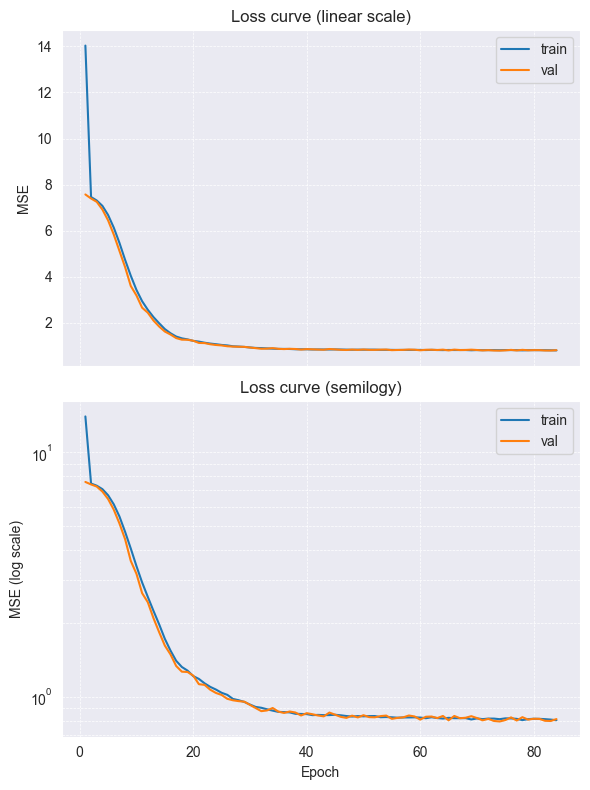

In [29]:
history = myNN.fit(train_ds.batch(batch_size),
                   validation_data=val_ds.batch(batch_size),
                   epochs=200,
                   callbacks=[EarlyStopping(patience=10,
                                            restore_best_weights=True)]
                   )
myNN.summary()
plot_loss(history)